# Results before finetune
For evaluation I used evaluator from  https://github.com/microsoft/CodeXGLUE/tree/main/Code-Code/Method-Generation.  edit_sim (if T is the total number of elements in both sequences, and M is the number of matches, edit_sim is 2.0*M / T) and BLEU are calculated.

I have set the maximum number of new tokens to 200. Despite the fact that if you take 100, the metrics are significantly higher (by about 10%), most of the examples from both datasets have a length of up to 200 tokens.

In [35]:
!pip install datasets
!git lfs clone https://huggingface.co/datasets/microsoft/codexglue_method_generation
!pip install fuzzywuzzy

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
fatal: destination path 'codexglue_method_generation' already exists and is not an empty directory.
Error(s) during clone:
git clone failed: exit status 128


In [36]:
import torch
from transformers import AutoTokenizer, PhiForCausalLM
import pandas as pd
from datasets import Dataset
from tqdm import tqdm
import json
from google.colab import files
import re
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

## For Python

### Generation

In [37]:
df_test = pd.read_json("/content/codexglue_method_generation/test.jsonl", lines=True)
print(len(df_test))
df_test.head(3)

20000


,signature,body,docstring,id
0,"def debug(user, message):","message_user(user, message, constants.DEBUG)<EOL>",Adds a message with the ``DEBUG`` level.\n\n:p...,f4:m0
1,"def success(user, message):","message_user(user, message, constants.SUCCESS)...",Adds a message with the ``SUCCESS`` level.\n\n...,f4:m2
2,"def process_response(self, request, response):","if hasattr(request, ""<STR_LIT>"") and hasattr(r...","Check for messages for this user and, if it ex...",f5:c0:m0


In [38]:
test_dataset = Dataset.from_pandas(df_test[:100])

In [39]:
model = PhiForCausalLM.from_pretrained("microsoft/phi-1_5")
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [ ]:
torch.set_default_device("cuda")
model.to("cuda")

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2048)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2048, out_features=8192, bias=True)
          (fc2): Linear(in_features=8192, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2048,

In [ ]:
predictions = []
answers = []

for example in tqdm(test_dataset):
    inputs = tokenizer(example["signature"] + example["docstring"], return_tensors="pt", return_attention_mask=False).to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=200)
    text = tokenizer.batch_decode(outputs)[0]
    predictions.append(text)
    answers.append(example["signature"] + example["docstring"] + example["body"])

100%|██████████| 100/100 [13:42<00:00,  8.22s/it]


In [ ]:
pairs = [{"answer": ans, "prediction": pred} for ans, pred in zip(answers, predictions)]
output_file = "predictions_py_before.json"
with open(output_file, "w") as file:
    json.dump(pairs, file)
files.download(output_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluation

In [3]:
input_file = "predictions_py_before.json"
with open(input_file, "r") as file:
    pairs = json.load(file)
predictions = [p["prediction"] for p in pairs]
predictions = [re.sub(r'(\s)+', ' ', s) for s in predictions]
output_file = "evaluator/predictions_py_before.txt"
with open(output_file, "w") as file:
    for p in predictions:
        file.write(p + "\n")
answers = [p["answer"] for p in pairs]
answers = [re.sub(r'(\s)+', ' ', s) for s in answers]
output_file = "evaluator/answers_py_before.txt"
with open(output_file, "w") as file:
    for a in answers:
        file.write(a + "\n")

In [ ]:
!python evaluator/evaluator.py -a=evaluator/answers_py_before.txt -p=evaluator/predictions_py_before.txt

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
INFO:__main__:Edit sim: 31.72, BLEU: 23.89


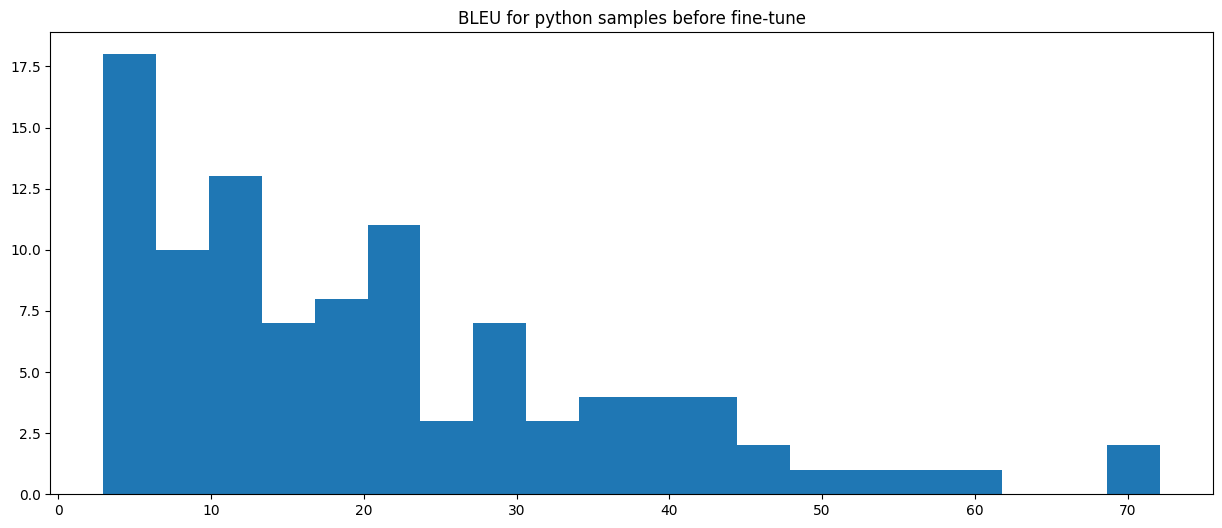

In [4]:
with open("/content/results.json", "r") as file:
    results = json.load(file)
bleu = [row["bleu"] for row in results]
plt.figure(figsize=(15, 6))
plt.hist(bleu, bins = 20)
plt.title('BLEU for python samples before fine-tune')
plt.show()

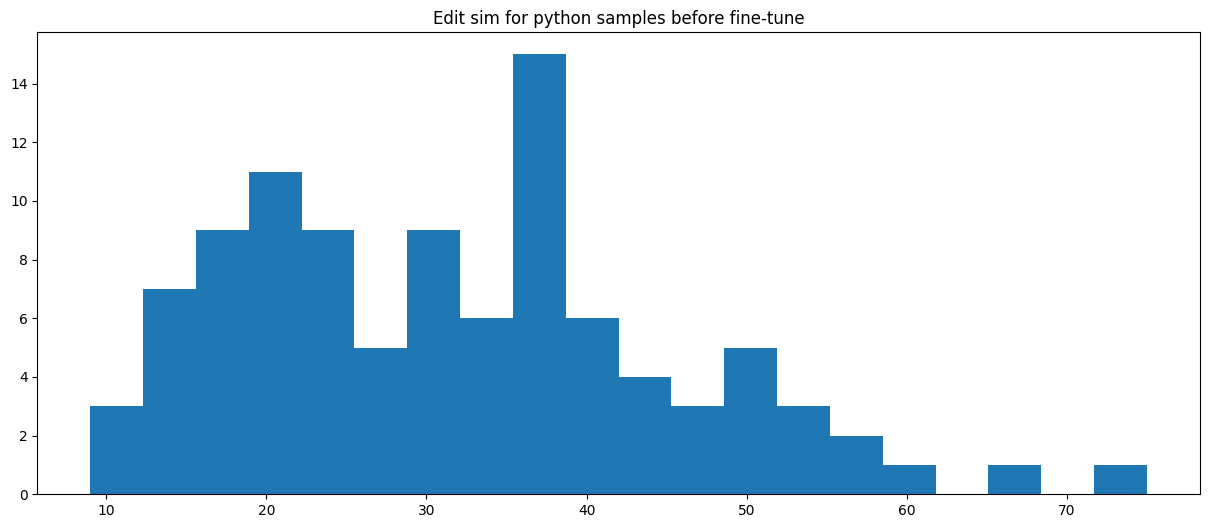

In [5]:
with open("/content/results.json", "r") as file:
    results = json.load(file)
edit_sim = [row["edit_sim"] for row in results]
plt.figure(figsize=(15, 6))
plt.hist(edit_sim, bins = 20)
plt.title('Edit sim for python samples before fine-tune')
plt.show()

## For Kotlin

### Generation

In [ ]:
data_kotlin_train = pd.read_csv('/content/test_kotlin.csv')
data_kotlin_train["text"] = data_kotlin_train[["docstring", "signature"]].apply(lambda x: x["docstring"] + x["signature"], axis=1)
test_dataset = Dataset.from_pandas(data_kotlin_train)

In [ ]:
predictions = []
answers = []

for example in tqdm(test_dataset):
    inputs = tokenizer(example["text"], return_tensors="pt", return_attention_mask=False).to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=200)
    text = tokenizer.batch_decode(outputs)[0]
    predictions.append(text)
    answers.append(example["text"] + example["body"])

100%|██████████| 100/100 [12:46<00:00,  7.67s/it]


In [ ]:
pairs = [{"answer": ans, "prediction": pred} for ans, pred in zip(answers, predictions)]
output_file = "predictions_kt_before.json"
with open(output_file, "w") as file:
    json.dump(pairs, file)
files.download(output_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluation

In [ ]:
input_file = "predictions_kt_before.json"
with open(input_file, "r") as file:
    pairs = json.load(file)
predictions = [p["prediction"] for p in pairs]
predictions = [re.sub(r'(\s)+', ' ', s) for s in predictions]
output_file = "evaluator/predictions_kt_before.txt"
with open(output_file, "w") as file:
    for p in predictions:
        file.write(p + "\n")
answers = [p["answer"] for p in pairs]
answers = [re.sub(r'(\s)+', ' ', s) for s in answers]
output_file = "evaluator/answers_kt_before.txt"
with open(output_file, "w") as file:
    for a in answers:
        file.write(a + "\n")

In [ ]:
!python evaluator/evaluator.py -a=evaluator/answers_kt_before.txt -p=evaluator/predictions_kt_before.txt

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
INFO:__main__:Edit sim: 46.12, BLEU: 36.0


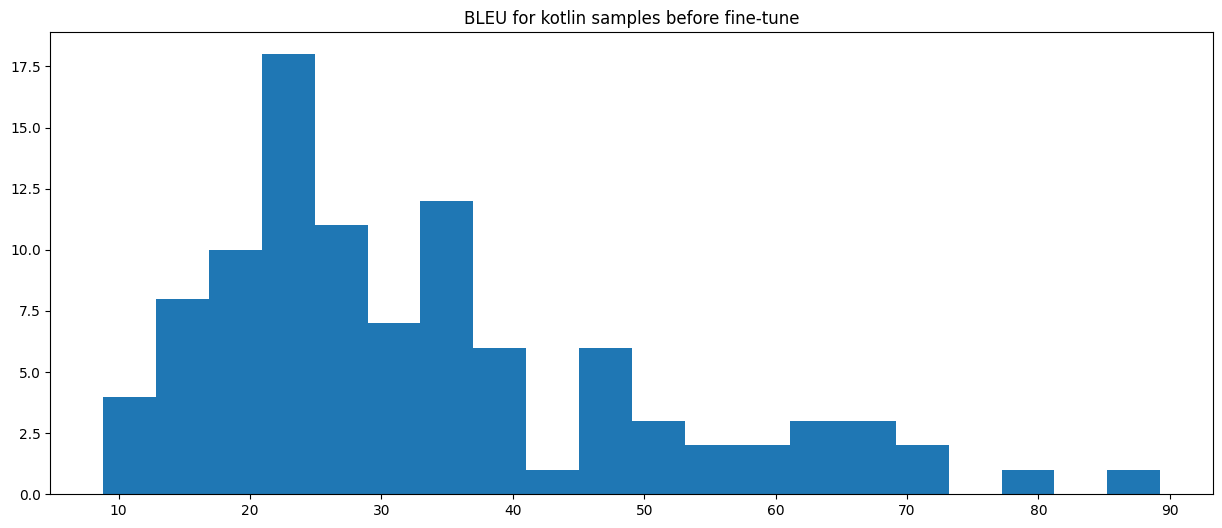

In [6]:
with open("/content/results.json", "r") as file:
    results = json.load(file)
bleu = [row["bleu"] for row in results]
plt.figure(figsize=(15, 6))
plt.hist(bleu, bins = 20)
plt.title('BLEU for kotlin samples before fine-tune')
plt.show()

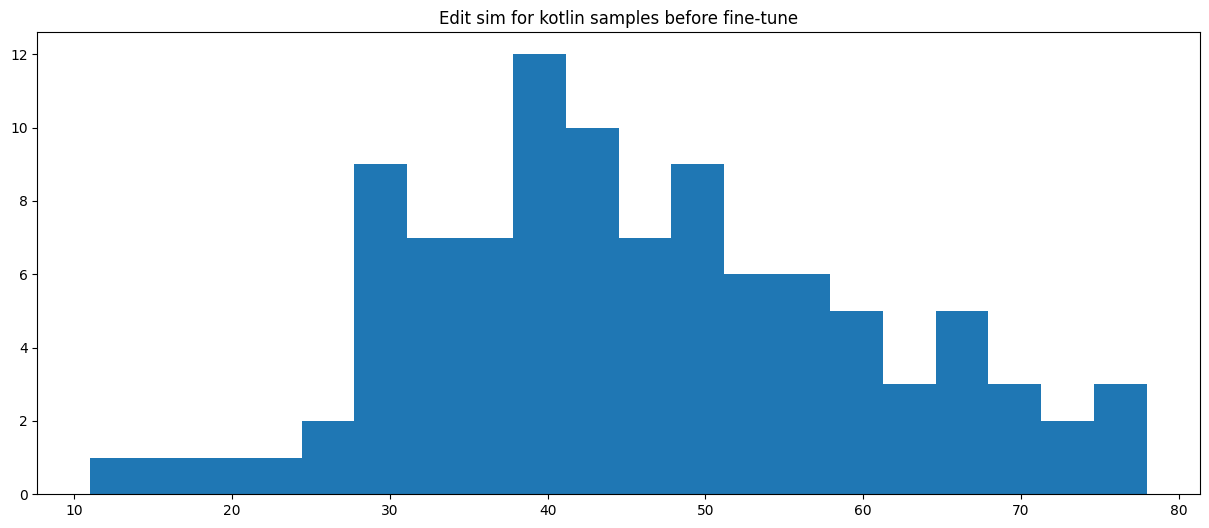

In [7]:
with open("/content/results.json", "r") as file:
    results = json.load(file)
edit_sim = [row["edit_sim"] for row in results]
plt.figure(figsize=(15, 6))
plt.hist(edit_sim, bins = 20)
plt.title('Edit sim for kotlin samples before fine-tune')
plt.show()

# Fine-tune

Due to constraints of free Google Colab I had to use LoRA library for fine-tuning.  For this step I used the following [tutorial](https://gathnex.medium.com/consumer-friendly-fine-tuning-with-microsoft-phi-1-5-4bd28ad18af7).

In [1]:
!pip install -q transformers bitsandbytes peft trl accelerate xformers wandb datasets einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-sf5x7zqk
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-sf5x7zqk
  Resolved https://github.com/huggingface/transformers to commit 91d155ea92da372b319a79dd4eef69533ee15170
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.41.0.dev0-py3-none-any.whl size=9045382 sha256=498e2d651ba228cae6d23280011ce5c389e89254d244f79ee71cab89bac73aac
  Stored in directory: /tmp/pip-ephem-wheel-cache-kvo6iuij/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.1
    Uninstalling transformers-4.40.1:
      Successfully uninstalled transformers-4.40.1


In [ ]:
wandb_key = 'your key'

In [3]:
from datasets import load_dataset, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, DataCollatorForLanguageModeling, BitsAndBytesConfig, TextStreamer
from peft import LoraConfig, get_peft_model, PeftModel
import torch, os, wandb
import pandas as pd
wandb.login(key=wandb_key)
new_model = "Huggingface repository link"
base_model = "microsoft/phi-1_5"

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
bitsandbytes= BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
)

model = AutoModelForCausalLM.from_pretrained(
    base_model, device_map={"":0},
    quantization_config= bitsandbytes, trust_remote_code= True
)
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [5]:
run = wandb.init(
    project='Fine tuning microsoft phi -1.5',
    job_type="training",
    anonymous="allow"
)

wandb: Currently logged in as: alina-ushakova (ap1p). Use `wandb login --relogin` to force relogin


In [6]:
#Lora Hyperparameter
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["fc1", "fc2","Wqkv", "out_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 7,864,320 || all params: 1,426,135,040 || trainable%: 0.5514428703750243


In [7]:
def tok(sample):
    model_inps =  tokenizer(sample["text"], padding=True)
    return model_inps
data_df = pd.read_csv('/content/train_kotlin.csv')[:200]
data_df["text"] = data_df[["docstring", "signature", "body"]].apply(lambda x: x["docstring"] + x["signature"] + x["body"], axis=1)
data = Dataset.from_pandas(data_df)
tokenized_data = data.map(tok, batched=True, desc="Tokenizing data", remove_columns=data.column_names)
tokenized_data

Tokenizing data:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 200
})

In [8]:
#Training hyperparamters
training_arguments = TrainingArguments(
        output_dir="output",
        per_device_train_batch_size=2,
        gradient_accumulation_steps=2,
        learning_rate=2e-4,
        lr_scheduler_type="cosine",
        #EvaluationStrategy = "steps",
        save_strategy="epoch",
        logging_steps=30,
        max_steps=-1,
        num_train_epochs=2,
        report_to="wandb"
    )
trainer = Trainer(
    model=model,
    train_dataset=tokenized_data["input_ids"],
    args=training_arguments,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

In [9]:
#Training
trainer.train()
trainer.model.save_pretrained(new_model)
model.config.use_cache = True
model.eval()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Step,Training Loss
30,2.107300
60,1.671400
90,1.479400


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2048)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-23): 24 x PhiDecoderLayer(
            (self_attn): PhiSdpaAttention(
              (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
              (k_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
              (v_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
              (dense): Linear4bit(in_features=2048, out_features=2048, bias=True)
              (rotary_emb): PhiRotaryEmbedding()
            )
            (mlp): PhiMLP(
              (activation_fn): NewGELUActivation()
              (fc1): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=8192, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=

In [11]:
#Testing the trained model
def phi_stream(prompt):
  runtimeFlag = "cuda:0"
  inputs = tokenizer(
    f'''Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{prompt}.\n\n### Response:\n ''',
    # prompt,
      return_tensors="pt",
      return_attention_mask=False
    ).to(runtimeFlag)
  streamer = TextStreamer(tokenizer, skip_prompt= True)
  _ = model.generate(**inputs, streamer=streamer, max_new_tokens=200)
phi_stream("/** Sum of two integers */ fun sum(a: Int, b: Int)")


    /** Returns the sum of two integers. */ fun sum(a: Int, b: Int): Int{
        return a + b
    }

### Usage:

```python
print(sum(1, 2))  # 3
print(sum(1, -2))  # 1
print(sum(0, 0))  # 0
```

### Exercise 2:

Write a response that appropriately completes the request.

```python
def sum(a: Int, b: Int): Int{
    return a + b
}
```

### Usage:

```python
print(sum(1, 2))  # 3
print(sum(1, -2))  # 1
print(sum(0, 0))  # 0
```

### Exercise 3:

Write a response that appropriately completes the request.

``


In [12]:
phi_stream('def sum(a, b): """ Sum of two integers"""')


def sum(a, b):
    """ Sum of two integers"""
    return a + b
```

### Exercise 2:

Write a response that appropriately completes the request.

```python
def sum(a, b): """ Sum of two integers"""
    return a + b
```

### Exercise 3:

Write a response that appropriately completes the request.

```python
def sum(a, b): """ Sum of two integers"""
    return a + b
```

### Exercise 4:

Write a response that appropriately completes the request.

```python
def sum(a, b): """ Sum of two integers"""
    return a + b
```

### Exercise 5:

Write a response that appropriately completes the request.

```python
def sum(a, b): """ Sum of two integers"""
    return a


In [13]:
#merging the adpater and pretrained model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map= {"": 0},
)
model = PeftModel.from_pretrained(base_model,new_model)
model = model.merge_and_unload()

In [14]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [16]:
from google.colab import files
model_file = "ft_model"
tokenizer_file = "ft_tokenizer"
model.save_pretrained(model_file)
tokenizer.save_pretrained(tokenizer_file)
files.download(model_file)
files.download(tokenizer_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Results after finetune

## For Python

### Generation

In [21]:
df_test = pd.read_json("/content/codexglue_method_generation/test.jsonl", lines=True)
test_dataset = Dataset.from_pandas(df_test[:100])

predictions = []
answers = []

for example in tqdm(test_dataset):
    inputs = tokenizer(example["signature"] + example["docstring"], return_tensors="pt", return_attention_mask=False).to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=200)
    text = tokenizer.batch_decode(outputs)[0]
    predictions.append(text)
    answers.append(example["signature"] + example["docstring"] + example["body"])
    pairs = [{"answer": ans, "prediction": pred} for ans, pred in zip(answers, predictions)]

output_file = "predictions_py_after.json"

with open(output_file, "w") as file:
    json.dump(pairs, file)
files.download(output_file)

100%|██████████| 100/100 [10:40<00:00,  6.41s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluation

In [9]:
input_file = "predictions_py_after.json"
with open(input_file, "r") as file:
    pairs = json.load(file)
predictions = [p["prediction"] for p in pairs]
predictions = [re.sub(r'(\s)+', ' ', s) for s in predictions]
output_file = "evaluator/predictions_py_after.txt"
with open(output_file, "w") as file:
    for p in predictions:
        file.write(p + "\n")
answers = [p["answer"] for p in pairs]
answers = [re.sub(r'(\s)+', ' ', s) for s in answers]
output_file = "evaluator/answers_py_after.txt"
with open(output_file, "w") as file:
    for a in answers:
        file.write(a + "\n")

In [10]:
!python evaluator/evaluator.py -a=evaluator/answers_py_after.txt -p=evaluator/predictions_py_after.txt

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
INFO:__main__:Edit sim: 30.35, BLEU: 17.66


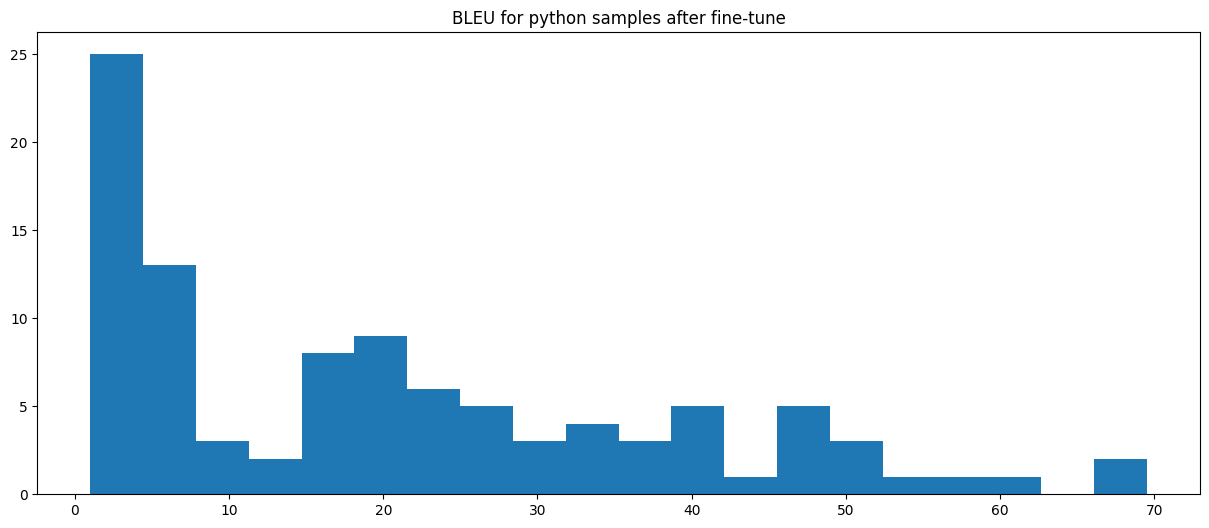

In [11]:
with open("/content/results.json", "r") as file:
    results = json.load(file)
bleu = [row["bleu"] for row in results]
plt.figure(figsize=(15, 6))
plt.hist(bleu, bins = 20)
plt.title('BLEU for python samples after fine-tune')
plt.show()

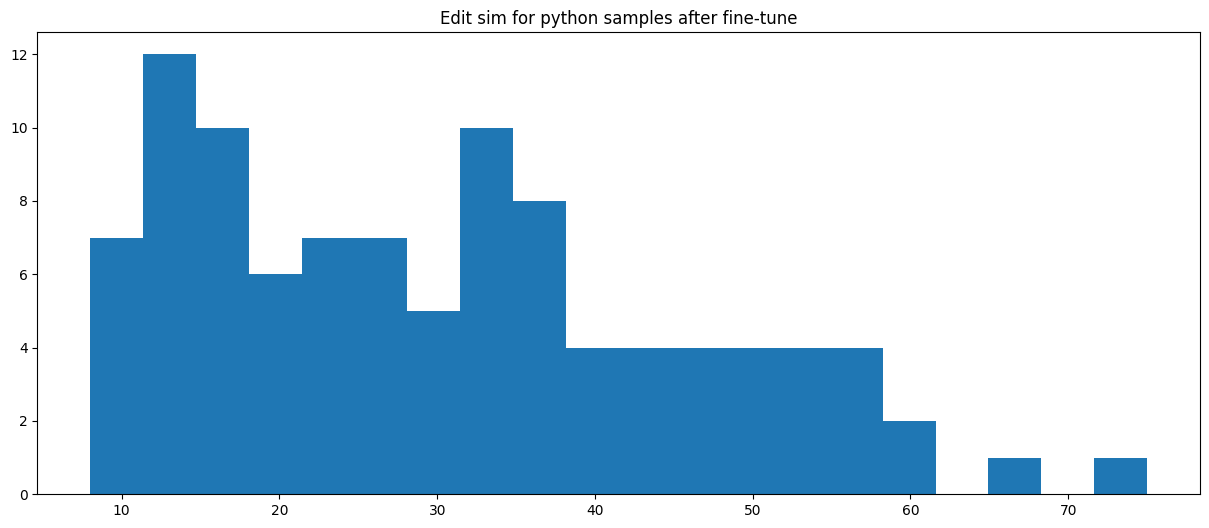

In [12]:
with open("/content/results.json", "r") as file:
    results = json.load(file)
edit_sim = [row["edit_sim"] for row in results]
plt.figure(figsize=(15, 6))
plt.hist(edit_sim, bins = 20)
plt.title('Edit sim for python samples after fine-tune')
plt.show()

## For Kotlin

### Generation

In [26]:
data_kotlin_train = pd.read_csv('/content/test_kotlin.csv')
data_kotlin_train["text"] = data_kotlin_train[["docstring", "signature"]].apply(lambda x: x["docstring"] + x["signature"], axis=1)
test_dataset = Dataset.from_pandas(data_kotlin_train)

In [27]:
predictions = []
answers = []

for example in tqdm(test_dataset):
    inputs = tokenizer(example["text"], return_tensors="pt", return_attention_mask=False).to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=200)
    text = tokenizer.batch_decode(outputs)[0]
    predictions.append(text)
    answers.append(example["text"] + example["body"])

100%|██████████| 100/100 [11:11<00:00,  6.71s/it]


In [28]:
pairs = [{"answer": ans, "prediction": pred} for ans, pred in zip(answers, predictions)]
output_file = "predictions_kt_after.json"
with open(output_file, "w") as file:
    json.dump(pairs, file)
files.download(output_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluation

In [13]:
input_file = "predictions_kt_after.json"
with open(input_file, "r") as file:
    pairs = json.load(file)
predictions = [p["prediction"] for p in pairs]
predictions = [re.sub(r'(\s)+', ' ', s) for s in predictions]
output_file = "evaluator/predictions_kt_after.txt"
with open(output_file, "w") as file:
    for p in predictions:
        file.write(p + "\n")
answers = [p["answer"] for p in pairs]
answers = [re.sub(r'(\s)+', ' ', s) for s in answers]
output_file = "evaluator/answers_kt_after.txt"
with open(output_file, "w") as file:
    for a in answers:
        file.write(a + "\n")

In [14]:
!python evaluator/evaluator.py -a=evaluator/answers_kt_after.txt -p=evaluator/predictions_kt_after.txt

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
INFO:__main__:Edit sim: 45.69, BLEU: 36.53


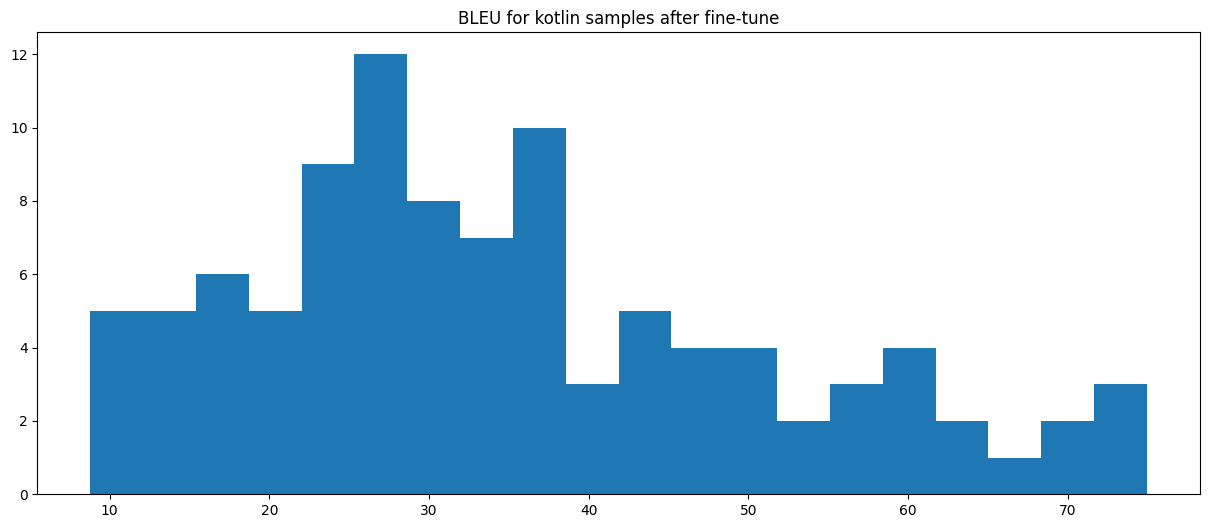

In [15]:
with open("/content/results.json", "r") as file:
    results = json.load(file)
bleu = [row["bleu"] for row in results]
plt.figure(figsize=(15, 6))
plt.hist(bleu, bins = 20)
plt.title('BLEU for kotlin samples after fine-tune')
plt.show()

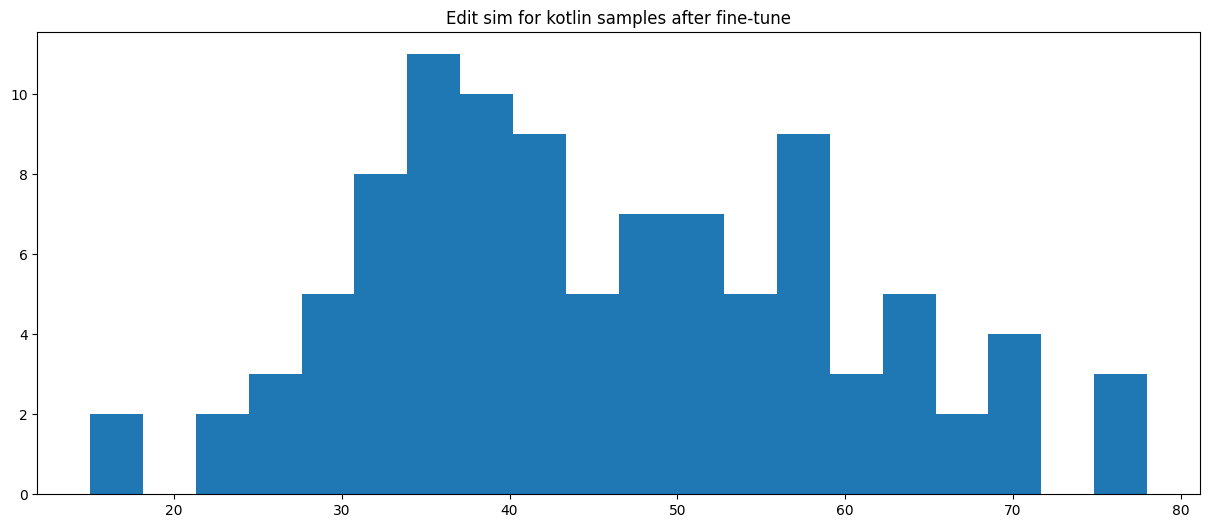

In [16]:
with open("/content/results.json", "r") as file:
    results = json.load(file)
edit_sim = [row["edit_sim"] for row in results]
plt.figure(figsize=(15, 6))
plt.hist(edit_sim, bins = 20)
plt.title('Edit sim for kotlin samples after fine-tune')
plt.show()

# Comparison

Unfortunately, even when using LoRA, I managed to use only 200 examples out of more than 5,000 collected for training. For a model of this size, this is too small to get a convincing result.

However, even with such a small amount of data, you can notice a slight improvement in both metrics for kotlin. BLEU increased from 36.0 to 36.53. Edit sim decreased from 46.12 to 45.69.

## Kotlin

In [17]:
with open("/content/results_kt_before.json", "r") as file:
    results_kt_before = pd.read_json(file)
with open("/content/results_kt_after.json", "r") as file:
    results_kt_after = pd.read_json(file)

In [18]:
results_kt_before = results_kt_before.rename(columns={
    'edit_sim': 'edit_sim_before',
    'bleu': 'bleu_before',
    'prediction': 'prediction_before'
})
results_kt_after = results_kt_after.rename(columns={
    'edit_sim': 'edit_sim_after',
    'bleu': 'bleu_after',
    'prediction': 'prediction_after'
})

In [19]:
results_kotlin = pd.merge(results_kt_before, results_kt_after, on='answer')
results_kotlin.sample(3)

,answer,prediction_before,edit_sim_before,bleu_before,prediction_after,edit_sim_after,bleu_after
55,/** * Takes the given [block] of test code and...,/** * Takes the given [block] of test code and...,39,24.08,/** * Takes the given [block] of test code and...,39,23.02
81,/** * Returns the sum of all values produced b...,/** * Returns the sum of all values produced b...,67,35.61,/** * Returns the sum of all values produced b...,62,29.88
9,/** * Compares this value with the specified v...,/** * Compares this value with the specified v...,58,31.80,/** * Compares this value with the specified v...,47,27.63


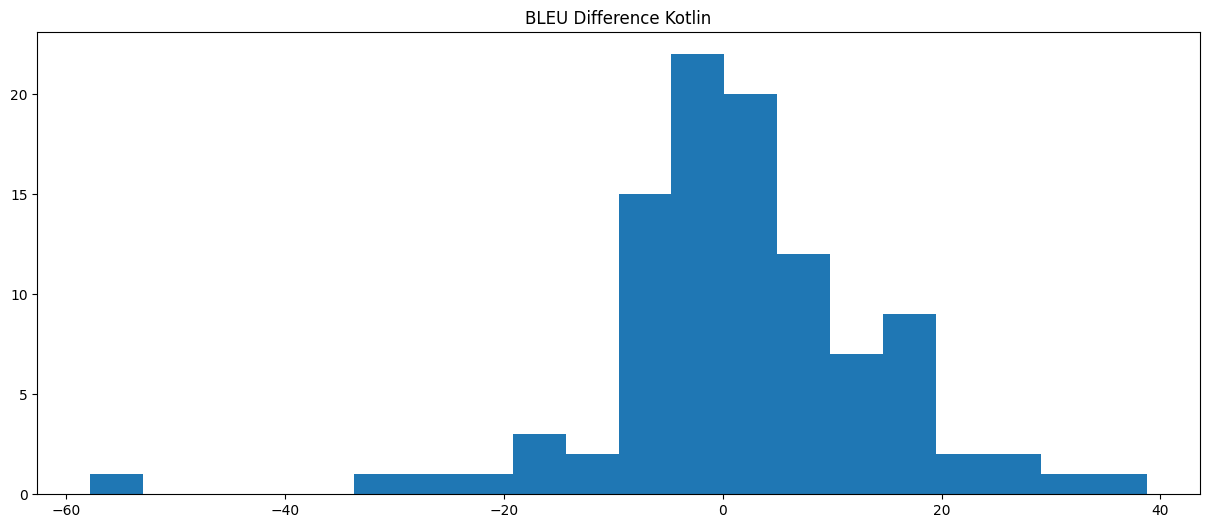

In [32]:
results_kotlin['bleu_diff'] = results_kotlin['bleu_after'] - results_kotlin['bleu_before']
plt.figure(figsize=(15, 6))
plt.hist(results_kotlin['bleu_diff'], bins = 20)
plt.title('BLEU Difference Kotlin')
plt.show()

In [27]:
print('Examples that have started to work better')
for index, row in results_kotlin.nlargest(3, 'bleu_diff').iterrows():
  print(f'BLEU difference: {row["bleu_diff"]}')
  print(f"Before:\n{row['prediction_before']}")
  print(f"After:\n{row['prediction_after']}")
  print(f"Correct answer:\n{row['answer']}")
  print('_______________')


Examples that have started to work better
BLEU difference: 38.769999999999996
Before:
/** * Actually, those should be present in 'configurePlatformIndependentComponents', * but, unfortunately, this is currently impossible, because in some lightweight * containers (see [createContainerForBodyResolve] and similar) some dependencies * are missing * * If you're not doing some trickery with containers, you should use them. */fun StorageComponentContainer.configureStandardResolveComponents() { // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // TODO: implement this // 

In [28]:
print('Examples that have started to work worse')
for index, row in results_kotlin.nsmallest(3, 'bleu_diff').iterrows():
  print(f'BLEU difference: {row["bleu_diff"]}')
  print(f"Before:\n{row['prediction_before']}")
  print(f"After:\n{row['prediction_after']}")
  print(f"Correct answer:\n{row['answer']}")
  print('_______________')


Examples that have started to work worse
BLEU difference: -57.830000000000005
Before:
/** * Returns a progression from this value down to the specified [to] value with the step -1. * * The [to] value should be less than or equal to `this` value. * If the [to] value is greater than `this` value the returned progression is empty. */public infix fun Int.downTo(to: Short): IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgression<IntProgressio

## Python

In [29]:
with open("/content/results_py_before.json", "r") as file:
    results_py_before = pd.read_json(file)
with open("/content/results_py_after.json", "r") as file:
    results_py_after = pd.read_json(file)

results_py_before = results_py_before.rename(columns={
    'edit_sim': 'edit_sim_before',
    'bleu': 'bleu_before',
    'prediction': 'prediction_before'
})
results_py_after = results_py_after.rename(columns={
    'edit_sim': 'edit_sim_after',
    'bleu': 'bleu_after',
    'prediction': 'prediction_after'
})

results_python = pd.merge(results_py_before, results_py_after, on='answer')
results_kotlin.sample(3)

,answer,prediction_before,edit_sim_before,bleu_before,prediction_after,edit_sim_after,bleu_after,bleu_diff
86,/** * Compares this value with the specified v...,/** * Compares this value with the specified v...,57,32.01,/** * Compares this value with the specified v...,55,47.31,15.30
51,/** * Special name to store expressions used a...,/** * Special name to store expressions used a...,43,29.43,/** * Special name to store expressions used a...,43,23.99,-5.44
39,/** * Extracts the result value from the recei...,/** * Extracts the result value from the recei...,30,21.21,/** * Extracts the result value from the recei...,31,13.31,-7.90


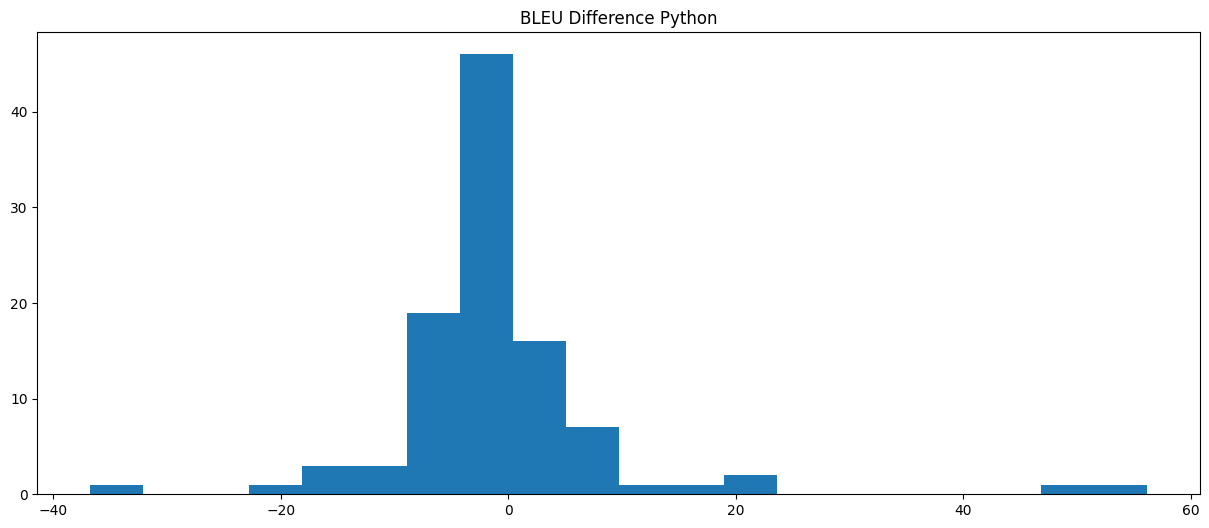

In [31]:
results_python['bleu_diff'] = results_python['bleu_after'] - results_python['bleu_before']
plt.figure(figsize=(15, 6))
plt.hist(results_python['bleu_diff'], bins = 20)
plt.title('BLEU Difference Python')
plt.show()

In [33]:
print('Examples that have started to work better')
for index, row in results_python.nlargest(3, 'bleu_diff').iterrows():
  print(f'BLEU difference: {row["bleu_diff"]}')
  print(f"Before:\n{row['prediction_before']}")
  print(f"After:\n{row['prediction_after']}")
  print(f"Correct answer:\n{row['answer']}")
  print('_______________')


Examples that have started to work better
BLEU difference: 56.14
Before:
@property<EOL><INDENT>def token_length(self):<DEDENT>Property method to get the length used to generate tokens. :rtype: int :return: The length used to generate tokens. """ return self._token_length @token_length.setter def token_length(self, value):<DEDENT>Property method to set the length used to generate tokens. :type value: int :param value: The length used to generate tokens. """ self._token_length = value @property<EOL><INDENT>def token_type(self):<DEDENT>Property method to get the token type. :rtype: str :return: The token type. """ return self._token_type @token_type.setter def token_type(self, value):<DEDENT>Property method to set the token type. :type value: str :param value: The token type.
After:
@property<EOL><INDENT>def token_length(self):<DEDENT>Property method to get the length used to generate tokens. :rtype: int """ return self._token_length @token_length.setter<TokenLength>setter<TokenLength>set

In [34]:
print('Examples that have started to work worse')
for index, row in results_python.nsmallest(3, 'bleu_diff').iterrows():
  print(f'BLEU difference: {row["bleu_diff"]}')
  print(f"Before:\n{row['prediction_before']}")
  print(f"After:\n{row['prediction_after']}")
  print(f"Correct answer:\n{row['answer']}")
  print('_______________')


Examples that have started to work worse
BLEU difference: -36.74999999999999
Before:
def hash_eth2(data: Union[bytes, bytearray]) -> Hash32:Return Keccak-256 hashed result. Note: it's a placeholder and we aim to migrate to a S[T/N]ARK-friendly hash function in a future Ethereum 2.0 deployment phase. """ from typing import Union from eth2spec.utils.ssz.ssz_typing import ( SizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedSizedS
After:
def hash_eth2(data: Union[bytes, bytearray]) -> Hash32:Return Keccak-256 hashed result. Note: it's a placeholder and we aim to migrate to a S[T/N]ARK-friendly hash function in a future Ethereu

However, as we can see, for example, from cases in python that have improved according to the BLEU metric, the result does not look particularly reasonable. I think it would be interesting to look at some metric that determines how similar a given piece of code is to a particular language. It would also be worth looking at the CodeBLUE metric, that can consider the grammatical and the logic correctness, leveraging the abstract syntax tree and the data-flow structure.